In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

讀取資料

In [2]:
with open('../data/output_clean_date_technical.json', 'r') as file:
    data = json.load(file)

merged_dict = {}

for item in data:
  if item == "historicalPriceFull":
    symbol = ""
    for entry in data[item]:
        if "symbol" in entry:
            symbol = data[item][entry]
        else:
            df = pd.json_normalize(data[item][entry])
            df["symbol"] = symbol
  else:
     df = pd.json_normalize(data[item])
  
  merged_dict[item] = df

In [3]:
stockprice_df = merged_dict["historicalPriceFull"]
stockprice_df

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,symbol
0,2024-01-12,33.70,33.80,33.60,33.75,33.750000,5221622,5221622,0.05,0.14837,33.72,"January 12, 24",0.001484,1101.TW
1,2024-01-11,33.70,33.80,33.60,33.70,33.700000,6590499,6590499,0.00,0.00000,33.70,"January 11, 24",0.000000,1101.TW
2,2024-01-10,34.05,34.05,33.70,33.70,33.700000,10231832,10231832,-0.35,-1.03000,33.82,"January 10, 24",-0.010300,1101.TW
3,2024-01-09,34.30,34.30,34.05,34.05,34.050000,6191243,6191243,-0.25,-0.72886,34.13,"January 09, 24",-0.007289,1101.TW
4,2024-01-08,34.40,34.55,34.25,34.25,34.250000,5522713,5522713,-0.15,-0.43605,34.35,"January 08, 24",-0.004360,1101.TW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2021-01-20,37.87,37.91,37.09,37.23,33.397839,38529978,38529978,-0.64,-1.69000,37.41,"January 20, 21",-0.016900,1101.TW
732,2021-01-19,37.82,38.18,37.82,37.96,34.050301,13261660,13261660,0.14,0.37017,37.99,"January 19, 21",0.003702,1101.TW
733,2021-01-18,38.14,38.14,37.64,37.82,33.927963,27598255,27598255,-0.32,-0.83901,37.87,"January 18, 21",-0.008390,1101.TW
734,2021-01-15,38.64,38.64,38.14,38.14,34.213417,33681520,33681520,-0.50,-1.29000,38.31,"January 15, 21",-0.012900,1101.TW


---

確認資料狀況

In [4]:
stockprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              736 non-null    object 
 1   open              736 non-null    float64
 2   high              736 non-null    float64
 3   low               736 non-null    float64
 4   close             736 non-null    float64
 5   adjClose          736 non-null    float64
 6   volume            736 non-null    int64  
 7   unadjustedVolume  736 non-null    int64  
 8   change            736 non-null    float64
 9   changePercent     736 non-null    float64
 10  vwap              736 non-null    float64
 11  label             736 non-null    object 
 12  changeOverTime    736 non-null    float64
 13  symbol            736 non-null    object 
dtypes: float64(9), int64(2), object(3)
memory usage: 80.6+ KB


In [5]:
# check date
stockprice_df['label_date'] = pd.to_datetime(stockprice_df['label'])
stockprice_df['date'] = pd.to_datetime(stockprice_df['date'])
print(f"Number of 'label_date != date': {len(stockprice_df[stockprice_df['label_date'] != stockprice_df['date']])}")

Number of 'label_date != date': 0


/tmp/ipykernel_786307/304800840.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stockprice_df['label_date'] = pd.to_datetime(stockprice_df['label'])


In [6]:
# check if any columns is NaN
print(f"Number of NaN:\n{stockprice_df.isna().sum()}")

Number of NaN:
date                0
open                0
high                0
low                 0
close               0
adjClose            0
volume              0
unadjustedVolume    0
change              0
changePercent       0
vwap                0
label               0
changeOverTime      0
symbol              0
label_date          0
dtype: int64


In [7]:
# check if duplicate
print(f"Number of duplicate: {len(stockprice_df[stockprice_df.duplicated()])}")

Number of duplicate: 0


尋找相關性

In [8]:
# 去除不考慮的欄位
stockprice_df.drop(columns=['label', 'label_date'], inplace=True)

In [9]:
# 假設 stockprice_df 已經被讀取並包含所有必要的欄位
stockprice_df['date'] = pd.to_datetime(stockprice_df['date'])
stockprice_df = stockprice_df.sort_values(['symbol', 'date'])

# 創建90天後的收盤價目標變量
stockprice_df['close_90d'] = stockprice_df.groupby('symbol')['close'].shift(-90)

# 移除close_90d是NaN的行
stockprice_df_with_90d = stockprice_df[stockprice_df['close_90d'].notna()]

# 定義計算相關性的函數
def calculate_correlation(group):
    group.drop(columns=['symbol', 'date'], inplace=True)
    correlation_matrix = group.corr()
    return correlation_matrix['close_90d']

# 對每個股票分組計算相關性
correlation_by_symbol = stockprice_df_with_90d.groupby('symbol').apply(calculate_correlation)
print(correlation_by_symbol)

close_90d      open      high       low     close  adjClose    volume  \
symbol                                                                  
1101.TW    0.538489  0.541924  0.535744  0.539279  0.336895  0.160779   

close_90d  unadjustedVolume    change  changePercent      vwap  \
symbol                                                           
1101.TW            0.160779  0.030436       0.039478  0.539604   

close_90d  changeOverTime  close_90d  
symbol                                
1101.TW          0.039478        1.0  


/tmp/ipykernel_786307/2065797045.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_symbol = stockprice_df_with_90d.groupby('symbol').apply(calculate_correlation)


1101.TW correlation: close_90d
open                0.538489
high                0.541924
low                 0.535744
close               0.539279
adjClose            0.336895
volume              0.160779
unadjustedVolume    0.160779
change              0.030436
changePercent       0.039478
vwap                0.539604
changeOverTime      0.039478
close_90d           1.000000
Name: 1101.TW, dtype: float64


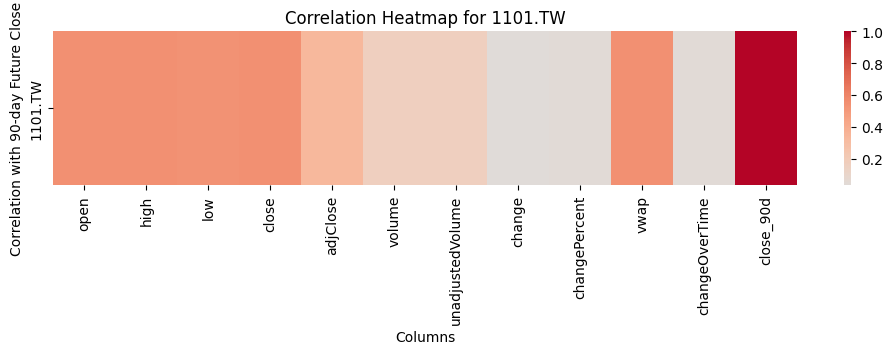

In [10]:
symbols = stockprice_df_with_90d['symbol'].unique()

for symbol in symbols:
    symbol_corr = correlation_by_symbol.loc[symbol]
    print(f"{symbol} correlation: {symbol_corr}")
    
    plt.figure(figsize=(12, 2))
    sns.heatmap(correlation_by_symbol, cmap='coolwarm', center=0)
    plt.title(f'Correlation Heatmap for {symbol}')
    plt.xlabel('Columns')
    plt.ylabel('Correlation with 90-day Future Close Price')
    plt.show()



---

In [11]:
techindex_df = merged_dict["tech60"]
techindex_df

,date,open,high,low,close,volume,sma,ema,wma,dema,tema,williams,rsi,adx,standardDeviation
0,2024-01-12 00:00:00,33.70,33.80,33.60,33.75,5221622,33.635000,34.108406,34.108033,33.950330,34.436972,-42.168675,47.432703,8.628102,1.020919
1,2024-01-11 00:00:00,33.70,33.80,33.60,33.70,6590499,33.604167,34.120555,34.103251,33.969270,34.479199,-43.373494,47.255419,8.747436,1.044641
2,2024-01-10 00:00:00,34.05,34.05,33.70,33.70,10231832,33.583333,34.134811,34.099426,33.992654,34.528996,-43.373494,47.255419,8.868792,1.054935
3,2024-01-09 00:00:00,34.30,34.30,34.05,34.05,6191243,33.579167,34.149551,34.095464,34.017314,34.581758,-34.939759,48.359329,8.978488,1.054960
4,2024-01-08 00:00:00,34.40,34.55,34.25,34.25,5522713,33.571667,34.152925,34.079781,34.019580,34.602050,-30.120482,49.002555,9.041114,1.053184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2021-01-20 00:00:00,37.87,37.91,37.09,37.23,38529978,37.966000,38.567228,37.760667,38.462208,38.364473,-92.307692,0.000000,0.000000,0.469706
732,2021-01-19 00:00:00,37.82,38.18,37.82,37.96,13261660,38.150000,38.612558,38.026000,38.549308,38.490029,-74.803150,0.000000,0.000000,0.326343
733,2021-01-18 00:00:00,38.14,38.14,37.64,37.82,27598255,38.213333,38.634679,38.070000,38.591405,38.550093,-85.826772,0.000000,0.000000,0.354902
734,2021-01-15 00:00:00,38.64,38.64,38.14,38.14,33681520,38.410000,38.662295,38.320000,38.645171,38.628608,-100.000000,0.000000,0.000000,0.270000


In [12]:
techindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               736 non-null    object 
 1   open               736 non-null    float64
 2   high               736 non-null    float64
 3   low                736 non-null    float64
 4   close              736 non-null    float64
 5   volume             736 non-null    int64  
 6   sma                736 non-null    float64
 7   ema                736 non-null    float64
 8   wma                736 non-null    float64
 9   dema               736 non-null    float64
 10  tema               736 non-null    float64
 11  williams           736 non-null    float64
 12  rsi                736 non-null    float64
 13  adx                736 non-null    float64
 14  standardDeviation  736 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 86.4+ KB


In [13]:
# 確認是否有NaN
print(f"Number of NaN:\n{techindex_df.isna().sum()}")
# 確認是否有重複
print(f"Number of duplicate: {len(techindex_df[techindex_df.duplicated()])}")

Number of NaN:
date                 0
open                 0
high                 0
low                  0
close                0
volume               0
sma                  0
ema                  0
wma                  0
dema                 0
tema                 0
williams             0
rsi                  0
adx                  0
standardDeviation    0
dtype: int64
Number of duplicate: 0


In [14]:
techindex_df["sma"].isna().sum()

0

確認techIndex日期和stockprice_df日期是否一致

In [15]:
techindex_df['date'] = pd.to_datetime(techindex_df['date'])
techindex_df.sort_values(by='date', inplace=True)

# merge techindex_df and stockprice_df on date, and iterate stockprice_df symbol
for symbol in stockprice_df['symbol'].unique():
    stockprice_symbol = stockprice_df[stockprice_df['symbol'] == symbol]
    merged_df = pd.merge(stockprice_symbol, techindex_df, on='date', how='inner')
    print(f"Symbol: {symbol}, stockprice_df: {len(stockprice_symbol)}, techindex_df: {len(techindex_df)}, merged_df: {len(merged_df)}")

Symbol: 1101.TW, stockprice_df: 736, techindex_df: 736, merged_df: 736


In [16]:
techindex_df["sma"]

735    38.680000
734    38.410000
733    38.213333
732    38.150000
731    37.966000
         ...    
4      33.571667
3      33.579167
2      33.583333
1      33.604167
0      33.635000
Name: sma, Length: 736, dtype: float64

---

In [29]:
date_df = stockprice_df[["date"]]
date_df['date'] = pd.to_datetime(date_df['date'])
date_df['quarter'] = date_df['date'].dt.to_period('Q')
date_df

/tmp/ipykernel_786307/3599513635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['date'] = pd.to_datetime(date_df['date'])
/tmp/ipykernel_786307/3599513635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['quarter'] = date_df['date'].dt.to_period('Q')


,date,quarter
735,2021-01-14,2021Q1
734,2021-01-15,2021Q1
733,2021-01-18,2021Q1
732,2021-01-19,2021Q1
731,2021-01-20,2021Q1
...,...,...
4,2024-01-08,2024Q1
3,2024-01-09,2024Q1
2,2024-01-10,2024Q1
1,2024-01-11,2024Q1


In [25]:
financialGrowth_df = merged_dict["financialGrowth"]
financialGrowth_df.date.unique()

array(['2023-10-30', '2023-07-30', '2023-04-30', '2023-01-31',
       '2022-10-30', '2022-07-30', '2022-04-30', '2022-01-31',
       '2021-10-30', '2021-07-30', '2021-04-30', '2021-01-31'],
      dtype=object)

In [30]:
financial_df = pd.read_csv("../airflow/data/dim_financial.csv")
financial_df['date'] = pd.to_datetime(financial_df['date'])
financial_df['quarter'] = financial_df['date'].dt.to_period('Q')
financial_df

,date,symbol,cashFlowToDebtRatio,cashFlowAdequacyRatio,cashReinvestmentRatio,CashtoAssetsRatio,daysOfSalesOutstanding,assetTurnover,daysOfInventoryOutstanding,operatingCycle,grossProfitMargin,operatingProfitMargin,netProfitMargin,epsgrowth,returnOnEquity,debtRatio,longTermDebtToCapitalization,currentRatio,quickRatio,quarter
0,2022-07-30,1101.TW,-0.001605,5.392682,36.157024,-20.120597,133.846877,0.055669,65.770637,199.617514,0.004381,0.014697,-0.037363,-2.076923,-0.004694,0.379461,0.370270,2.097762,1.875490,2022Q3
1,2021-01-31,1101.TW,0.090264,206.346134,78.239353,6.036894,119.167997,0.082460,32.869741,152.037739,0.322976,0.264799,0.208354,-0.118644,0.032793,0.313505,0.283823,1.724033,1.604374,2021Q1
2,2023-01-31,1101.TW,0.018251,-97.836782,7.134514,-15.123415,109.350193,0.075206,49.133464,158.483656,0.149548,0.135603,0.071768,0.636364,0.011414,0.360119,0.352364,2.335134,2.106780,2023Q1
3,2021-10-30,1101.TW,0.000226,-32.402818,6.200555,-1.734754,140.040753,0.066972,46.600017,186.640769,0.192542,0.143446,0.148224,-0.475728,0.019753,0.332414,0.289821,1.840705,1.679605,2021Q4
4,2022-10-30,1101.TW,0.006366,-43.392684,-127.161192,-3.574154,115.361145,0.067846,55.723304,171.084450,0.082356,0.101821,0.048506,2.571429,0.007495,0.394716,0.395750,2.335155,2.089735,2022Q4
5,2021-07-30,1101.TW,0.046935,5.924074,180.762322,-14.230062,149.355315,0.072164,42.035490,191.390805,0.307615,0.251693,0.269176,0.980769,0.034726,0.287823,0.239571,1.877726,1.743359,2021Q3
6,2023-04-30,1101.TW,0.049546,-140.805041,18.517517,-110.515566,133.894138,0.056961,59.579816,193.473954,0.093901,0.076528,0.038243,-0.611111,0.004570,0.347936,0.349609,2.217271,1.989491,2023Q2
7,2022-04-30,1101.TW,0.013648,-2.767072,-161.810709,3.006631,160.353872,0.050732,58.144275,218.498147,0.086899,0.082800,0.037282,-0.824324,0.003988,0.368035,0.302815,1.650882,1.519839,2022Q2
8,2023-10-30,1101.TW,0.039739,6.837393,-12.478038,10.321149,129.494536,0.057097,56.996593,186.491129,0.213869,0.197702,0.046175,-0.622222,0.005606,0.349229,0.319284,1.731191,1.577710,2023Q4
9,2023-07-30,1101.TW,0.034637,-1.370718,-26.354314,22.336011,121.024327,0.060631,60.199491,181.223818,0.216311,0.235739,0.128013,2.214286,0.016529,0.343698,0.319988,1.682886,1.513824,2023Q3


In [23]:
financial_df["date"]

0    2022-07-30
1    2021-01-31
2    2023-01-31
3    2021-10-30
4    2022-10-30
5    2021-07-30
6    2023-04-30
7    2022-04-30
8    2023-10-30
9    2023-07-30
10   2021-04-30
11   2022-01-31
Name: date, dtype: datetime64[ns]

In [32]:
df = pd.merge(date_df, financial_df, on='quarter', how='left')

,date_x,quarter,date_y,symbol,cashFlowToDebtRatio,cashFlowAdequacyRatio,cashReinvestmentRatio,CashtoAssetsRatio,daysOfSalesOutstanding,assetTurnover,...,operatingCycle,grossProfitMargin,operatingProfitMargin,netProfitMargin,epsgrowth,returnOnEquity,debtRatio,longTermDebtToCapitalization,currentRatio,quickRatio
727,2024-01-02,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,2024-01-03,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729,2024-01-04,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,2024-01-05,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,2024-01-08,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732,2024-01-09,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
733,2024-01-10,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,2024-01-11,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
735,2024-01-12,2024Q1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
import pandas as pd

# 假設我們有以下兩個數據框
date_df = pd.DataFrame({
    'date': ['2021-01-01', '2021-01-15', '2021-02-01', '2021-03-01'],
})
financial_df = pd.DataFrame({
    'date': ['2021-01-31', '2021-02-28', '2021-03-31'],
    'cashFlowToDebtRatio': [0.1, 0.2, 0.3]
})

# 創建 'date_ym' 列
date_df['date'] = pd.to_datetime(date_df['date'])
date_df['date_ym'] = date_df['date'].dt.strftime('%Y-%m')

financial_df['date'] = pd.to_datetime(financial_df['date'])
financial_df['date_ym'] = financial_df['date'].dt.strftime('%Y-%m')

# 合併數據框
df = pd.merge(date_df, financial_df, on='date_ym', how='left')

# 刪除不需要的列
df.drop(columns=['date_ym', 'date_y'], inplace=True)

# 重命名列
df.rename(columns={'date_x': 'date'}, inplace=True)

print(df)

        date  cashFlowToDebtRatio
0 2021-01-01                  0.1
1 2021-01-15                  0.1
2 2021-02-01                  0.2
3 2021-03-01                  0.3
